## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil, itertools
from IPython.display import clear_output

RDKit WARNING: [13:49:26] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.2

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.00002
learn_opts.batch_size = 128

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
#!Important: For production, random train and test may be preferred
myopts.random_stratify = False
myopts.cache_dir = '/tmp/moldata'
#Important! If you repeat experiments within the same dataset version, set to False
myopts.clear_cache = False
myopts.train_keys = 'keys/keys_klifs'
myopts.kinase_list = 'keys/kinase_list'
#Important!: The newest version is 3, still 1 and 2 are acceptible
myopts.dataset_version = 3
myopts.cpu_count = 10

In [7]:
__ver = myopts.dataset_version
assert __ver in list(range(1, 4))
if __ver == 1:
    import dataset as ds
elif __ver == 2:
    import dataset2 as ds
else:
    import dataset3 as ds

### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))

        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify, kinase_check=False)

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(1068, 267, 374)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in test_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(1068, 267)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

### Start Learning

Epoch: 41	Lapse: 1.9s	Losses: (3.357, 1.131)	Best: (3.312, 1.131)


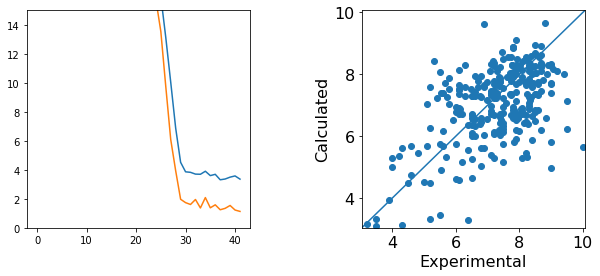

rmse: 1.217, mae: 0.957, r2: 0.534, rho: 0.428


3V8T,9.500,6.244,3.256
3FLY,8.400,5.882,2.518
3JXW,9.000,5.803,3.197
2YEX,10.000,5.662,4.338
4MBI,8.200,5.463,2.737
3D9V,8.233,5.322,2.911
2YWP,8.100,5.294,2.806
4RIO,9.000,4.964,4.036
2VTM,6.400,3.300,3.100


Epoch: 42	Lapse: 1.9s	Losses: (3.450, 1.494)	Best: (3.312, 1.131)
Epoch: 43	Lapse: 1.9s	Losses: (3.299, 1.360)	Best: (3.299, 1.131)
Epoch: 44	Lapse: 1.9s	Losses: (3.325, 1.362)	Best: (3.299, 1.131)
Epoch: 45	Lapse: 1.9s	Losses: (3.468, 1.388)	Best: (3.299, 1.131)
Epoch: 46	Lapse: 1.9s	Losses: (3.471, 1.257)	Best: (3.299, 1.131)
Epoch: 47	Lapse: 2.0s	Losses: (3.234, 1.455)	Best: (3.234, 1.131)
Epoch: 48	Lapse: 1.9s	Losses: (3.270, 1.235)	Best: (3.234, 1.131)
Epoch: 49	Lapse: 1.9s	Losses: (3.378, 1.248)	Best: (3.234, 1.131)
Epoch: 50	Lapse: 1.9s	Losses: (3.039, 1.558)	Best: (3.039, 1.131)
Epoch: 51	Lapse: 1.9s	Losses: (3.466, 1.470)	Best: (3.039, 1.131)
Epoch: 52	Lapse: 1.9s	Losses: (3.593, 1.824)	Best: (3.039, 1.131)
Epoch: 53	Lapse: 1.9s	Losses: (3.393, 1.495)	Best: (3.039, 1.131)
Epoch: 54	Lapse: 1.9s	Losses: (3.192, 1.696)	Best: (3.039, 1.131)


In [ ]:
CLEAR_OUTPUT_WHEN_UPDATE = True
SHOW_VERY_BAD_MOLS = True

model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()
best_train_loss, best_val_loss = np.inf, np.inf

Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    output = output or epoch == learn_opts.num_epochs - 1

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        L = list(itertools.chain.from_iterable(L))
        write_results_to_csv(L, X, y, np.abs(X-y), epoch)
        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))

    if output:
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))